In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
import tensorflow.keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [22]:
from skimage.color import rgb2gray
# import cv2
from scipy import ndimage

In [4]:
# base_skin_dir = os.path.join('..', 'input')
base_skin_dir = 'input'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [6]:
# imageid_path_dict

In [7]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [8]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,input/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,input/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [9]:
skin_df.count()

lesion_id        10015
image_id         10015
dx               10015
dx_type          10015
age               9958
sex              10015
localization     10015
path             10015
cell_type        10015
cell_type_idx    10015
dtype: int64

In [10]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [11]:
# Get general statistics for the dataset

skin_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0032451,nv,histo,male,back,input/HAM10000_images_part_2/ISIC_0032165.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


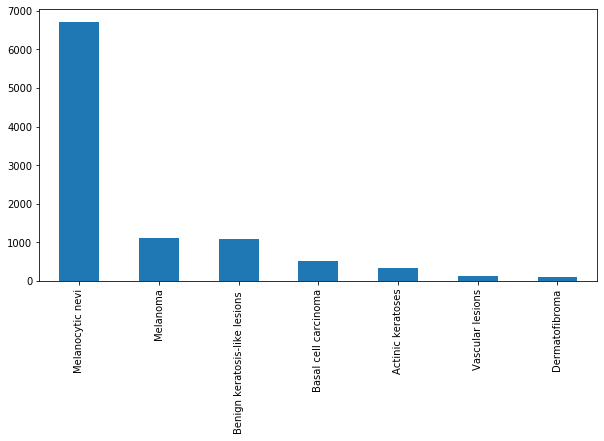

In [12]:
# Let's see the distribution of different cell types

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [13]:
skin_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [1]:
# Too many melanocytic nevi - let's balance it a bit!

skin_df = skin_df.drop(skin_df[skin_df.cell_type_idx == 4].iloc[:5705].index)
skin_df = skin_df.drop(skin_df[skin_df.cell_type_idx == 2].iloc[:99].index)
skin_df = skin_df.drop(skin_df[skin_df.cell_type_idx == 5].iloc[:113].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1, color=['black', 'red', 'green', 'blue', 'cyan'])

NameError: name 'skin_df' is not defined

In [15]:
skin_df['cell_type'].value_counts()

Melanocytic nevi                  1000
Melanoma                          1000
Benign keratosis-like lesions     1000
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [16]:
new_imageid_path_dict = pd.Series(skin_df.path.values,index=skin_df.image_id).to_dict()

In [19]:
new_imageid_path_dict

{'ISIC_0025876': 'input/HAM10000_images_part_1/ISIC_0025876.jpg',
 'ISIC_0025063': 'input/HAM10000_images_part_1/ISIC_0025063.jpg',
 'ISIC_0032463': 'input/HAM10000_images_part_2/ISIC_0032463.jpg',
 'ISIC_0025548': 'input/HAM10000_images_part_1/ISIC_0025548.jpg',
 'ISIC_0032306': 'input/HAM10000_images_part_2/ISIC_0032306.jpg',
 'ISIC_0032304': 'input/HAM10000_images_part_2/ISIC_0032304.jpg',
 'ISIC_0031639': 'input/HAM10000_images_part_2/ISIC_0031639.jpg',
 'ISIC_0027957': 'input/HAM10000_images_part_1/ISIC_0027957.jpg',
 'ISIC_0031212': 'input/HAM10000_images_part_2/ISIC_0031212.jpg',
 'ISIC_0032382': 'input/HAM10000_images_part_2/ISIC_0032382.jpg',
 'ISIC_0027533': 'input/HAM10000_images_part_1/ISIC_0027533.jpg',
 'ISIC_0029674': 'input/HAM10000_images_part_2/ISIC_0029674.jpg',
 'ISIC_0028607': 'input/HAM10000_images_part_1/ISIC_0028607.jpg',
 'ISIC_0024623': 'input/HAM10000_images_part_1/ISIC_0024623.jpg',
 'ISIC_0029613': 'input/HAM10000_images_part_2/ISIC_0029613.jpg',
 'ISIC_002

In [17]:
len(new_imageid_path_dict)

4098

In [20]:
count = 0
import datetime

In [23]:
currentDT = datetime.datetime.now()
print('Start Time: ')
print (str(currentDT))
for k,v in new_imageid_path_dict.items():
    image = plt.imread(v)
    gray = rgb2gray(image)
    gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
    for i in range(gray_r.shape[0]):
        if gray_r[i] > (gray_r.mean()*0.75):
            gray_r[i] = 1
        else:
            gray_r[i] = 0
    gray_t = gray_r.reshape(gray.shape[0],gray.shape[1])
    maskarr_img = Image.fromarray(np.uint8(gray_t * 255), 'L')
    mask_path = 'Mask_Images'
    mask_img_name = k + '_mask.jpg'
    maskarr_img.save(os.path.join(mask_path , mask_img_name))
    npMask = np.array(maskarr_img.convert("RGB"))
    cond = npMask<128
    pixels=np.where(cond, image, npMask)
    segarr_img = Image.fromarray(pixels)
    seg_path = 'Segmented_Images'
    seg_img_name = k + '_seg.jpg'
    segarr_img.save(os.path.join(seg_path , seg_img_name))
    count = count + 1
    print(count)
    currentDT = datetime.datetime.now()
#     print('End Time: ')
    print (str(currentDT))
currentDT = datetime.datetime.now()
print('End Time: ')
print (str(currentDT))

Start Time: 
2019-11-21 11:47:17.543363
1
2019-11-21 11:47:39.509455
2
2019-11-21 11:48:00.168708
3
2019-11-21 11:48:20.749627
4
2019-11-21 11:48:41.447993
5
2019-11-21 11:49:02.516655
6
2019-11-21 11:49:23.625889
7
2019-11-21 11:49:44.375587
8
2019-11-21 11:50:05.207474
9
2019-11-21 11:50:26.112330
10
2019-11-21 11:50:46.917331
11
2019-11-21 11:51:08.398105
12
2019-11-21 11:51:32.235293
13
2019-11-21 11:51:56.137173
14
2019-11-21 11:52:24.317021
15
2019-11-21 11:52:53.505697
16
2019-11-21 11:53:21.722034
17
2019-11-21 11:53:47.454565
18
2019-11-21 11:54:09.592381
19
2019-11-21 11:54:30.562505
20
2019-11-21 11:54:51.541611
21
2019-11-21 11:55:17.565405
22
2019-11-21 11:55:43.512320
23
2019-11-21 11:56:07.211474
24
2019-11-21 11:56:27.802776
25
2019-11-21 11:56:48.974782
26
2019-11-21 11:57:13.850460
27
2019-11-21 11:57:37.770104
28
2019-11-21 11:58:02.041998
29
2019-11-21 11:58:26.053499
30
2019-11-21 11:58:50.167403
31
2019-11-21 11:59:14.130516
32
2019-11-21 11:59:37.984338
33
2019-1

268
2019-11-21 13:26:25.410603
269
2019-11-21 13:26:46.512767
270
2019-11-21 13:27:07.274940
271
2019-11-21 13:27:28.065616
272
2019-11-21 13:27:48.542524
273
2019-11-21 13:28:09.069269
274
2019-11-21 13:28:29.773112
275
2019-11-21 13:28:50.925704
276
2019-11-21 13:29:11.868837
277
2019-11-21 13:29:32.890982
278
2019-11-21 13:29:53.521731
279
2019-11-21 13:30:14.256327
280
2019-11-21 13:30:36.034185
281
2019-11-21 13:30:56.511137
282
2019-11-21 13:31:17.461237
283
2019-11-21 13:31:38.649587
284
2019-11-21 13:31:59.689561
285
2019-11-21 13:32:21.368967
286
2019-11-21 13:32:42.419581
287
2019-11-21 13:33:03.505915
288
2019-11-21 13:33:24.627063
289
2019-11-21 13:33:45.163679
290
2019-11-21 13:34:05.736552
291
2019-11-21 13:34:26.687011
292
2019-11-21 13:34:48.265998
293
2019-11-21 13:35:08.712101
294
2019-11-21 13:35:29.681703
295
2019-11-21 13:35:51.532638
296
2019-11-21 13:36:13.102771
297
2019-11-21 13:36:34.246974
298
2019-11-21 13:36:55.419142
299
2019-11-21 13:37:16.347862
300
2019

533
2019-11-21 14:59:00.965937
534
2019-11-21 14:59:22.064794
535
2019-11-21 14:59:43.856081
536
2019-11-21 15:00:05.199587
537
2019-11-21 15:00:26.371294
538
2019-11-21 15:00:47.606819
539
2019-11-21 15:01:09.526034
540
2019-11-21 15:01:30.959477
541
2019-11-21 15:01:53.009854
542
2019-11-21 15:02:13.967223
543
2019-11-21 15:02:35.096365
544
2019-11-21 15:02:56.077795
545
2019-11-21 15:03:17.097765
546
2019-11-21 15:03:38.266212
547
2019-11-21 15:03:59.447042
548
2019-11-21 15:04:21.106544
549
2019-11-21 15:04:42.283112
550
2019-11-21 15:05:04.285093
551
2019-11-21 15:05:25.641663
552
2019-11-21 15:05:46.920708
553
2019-11-21 15:06:08.078459
554
2019-11-21 15:06:28.989116
555
2019-11-21 15:06:50.771282
556
2019-11-21 15:07:11.927305
557
2019-11-21 15:07:32.906559
558
2019-11-21 15:07:54.524746
559
2019-11-21 15:08:15.704477
560
2019-11-21 15:08:36.932033
561
2019-11-21 15:08:58.685686
562
2019-11-21 15:09:19.692622
563
2019-11-21 15:09:40.831270
564
2019-11-21 15:10:01.949553
565
2019

798
2019-11-21 16:32:52.436102
799
2019-11-21 16:33:13.975535
800
2019-11-21 16:33:35.172260
801
2019-11-21 16:33:56.585216
802
2019-11-21 16:34:17.650757
803
2019-11-21 16:34:38.987351
804
2019-11-21 16:34:59.817940
805
2019-11-21 16:35:21.128894
806
2019-11-21 16:35:42.450983
807
2019-11-21 16:36:03.250184
808
2019-11-21 16:36:24.745590
809
2019-11-21 16:36:46.254857
810
2019-11-21 16:37:07.564666
811
2019-11-21 16:37:28.340608
812
2019-11-21 16:37:50.075116
813
2019-11-21 16:38:11.157951
814
2019-11-21 16:38:32.839082
815
2019-11-21 16:38:54.079692
816
2019-11-21 16:39:15.142563
817
2019-11-21 16:39:36.839303
818
2019-11-21 16:39:58.476284
819
2019-11-21 16:40:20.053302
820
2019-11-21 16:40:40.938674
821
2019-11-21 16:41:02.387848
822
2019-11-21 16:41:23.518557
823
2019-11-21 16:41:45.272433
824
2019-11-21 16:42:06.132348
825
2019-11-21 16:42:27.892246
826
2019-11-21 16:42:49.047464
827
2019-11-21 16:43:10.148612
828
2019-11-21 16:43:31.120160
829
2019-11-21 16:43:52.283695
830
2019

1061
2019-11-21 18:14:44.569851
1062
2019-11-21 18:15:05.819963
1063
2019-11-21 18:15:28.824787
1064
2019-11-21 18:15:52.884441
1065
2019-11-21 18:16:16.674956
1066
2019-11-21 18:16:40.748010
1067
2019-11-21 18:17:04.346161
1068
2019-11-21 18:17:27.811851
1069
2019-11-21 18:17:51.331281
1070
2019-11-21 18:18:14.899248
1071
2019-11-21 18:18:38.501247
1072
2019-11-21 18:19:02.072586
1073
2019-11-21 18:19:25.531235
1074
2019-11-21 18:19:49.142715
1075
2019-11-21 18:20:12.598424
1076
2019-11-21 18:20:36.221437
1077
2019-11-21 18:20:59.803315
1078
2019-11-21 18:21:23.525280
1079
2019-11-21 18:21:47.106702
1080
2019-11-21 18:22:10.568348
1081
2019-11-21 18:22:34.283990
1082
2019-11-21 18:22:57.784004
1083
2019-11-21 18:23:21.453322
1084
2019-11-21 18:23:44.952926
1085
2019-11-21 18:24:08.346068
1086
2019-11-21 18:24:31.842214
1087
2019-11-21 18:24:55.302728
1088
2019-11-21 18:25:18.856036
1089
2019-11-21 18:25:42.354345
1090
2019-11-21 18:26:06.096161
1091
2019-11-21 18:26:29.909477
1092
201

1318
2019-11-21 19:56:36.925160
1319
2019-11-21 19:57:00.935050
1320
2019-11-21 19:57:24.720266
1321
2019-11-21 19:57:48.481208
1322
2019-11-21 19:58:12.239470
1323
2019-11-21 19:58:35.857549
1324
2019-11-21 19:58:59.274767
1325
2019-11-21 19:59:23.047047
1326
2019-11-21 19:59:46.563258
1327
2019-11-21 20:00:09.924305
1328
2019-11-21 20:00:33.613303
1329
2019-11-21 20:00:57.333504
1330
2019-11-21 20:01:20.942539
1331
2019-11-21 20:01:44.697786
1332
2019-11-21 20:02:08.191238
1333
2019-11-21 20:02:31.814993
1334
2019-11-21 20:02:55.473199
1335
2019-11-21 20:03:18.916273
1336
2019-11-21 20:03:42.755817
1337
2019-11-21 20:04:06.138762
1338
2019-11-21 20:04:29.880360
1339
2019-11-21 20:04:53.620828
1340
2019-11-21 20:05:17.037145
1341
2019-11-21 20:05:40.921795
1342
2019-11-21 20:06:04.459607
1343
2019-11-21 20:06:28.026835
1344
2019-11-21 20:06:51.749748
1345
2019-11-21 20:07:15.327670
1346
2019-11-21 20:07:38.739063
1347
2019-11-21 20:08:02.318615
1348
2019-11-21 20:08:25.666057
1349
201

1575
2019-11-21 21:34:45.453740
1576
2019-11-21 21:35:09.812730
1577
2019-11-21 21:35:33.569846
1578
2019-11-21 21:35:55.987268
1579
2019-11-21 21:36:17.320891
1580
2019-11-21 21:36:38.806830
1581
2019-11-21 21:36:59.750086
1582
2019-11-21 21:37:21.534131
1583
2019-11-21 21:37:43.113666
1584
2019-11-21 21:38:04.794924
1585
2019-11-21 21:38:27.359169
1586
2019-11-21 21:38:48.242642
1587
2019-11-21 21:39:10.602436
1588
2019-11-21 21:39:44.961710
1589
2019-11-21 21:40:06.737174
1590
2019-11-21 21:40:30.058191
1591
2019-11-21 21:40:50.563606
1592
2019-11-21 21:41:14.051780
1593
2019-11-21 21:41:35.692866
1594
2019-11-21 21:41:57.315745
1595
2019-11-21 21:42:20.693152
1596
2019-11-21 21:42:41.887730
1597
2019-11-21 21:43:02.457911
1598
2019-11-21 21:43:25.362771
1599
2019-11-21 21:43:46.025987
1600
2019-11-21 21:44:06.391555
1601
2019-11-21 21:44:27.212087
1602
2019-11-21 21:44:48.464292
1603
2019-11-21 21:45:09.762791
1604
2019-11-21 21:45:32.711756
1605
2019-11-21 21:45:53.963392
1606
201

1832
2019-11-21 23:15:14.080176
1833
2019-11-21 23:15:37.138871
1834
2019-11-21 23:16:00.262922
1835
2019-11-21 23:16:24.933758
1836
2019-11-21 23:16:48.063413
1837
2019-11-21 23:17:11.264262
1838
2019-11-21 23:17:34.373388
1839
2019-11-21 23:17:57.681655
1840
2019-11-21 23:18:20.712763
1841
2019-11-21 23:18:43.845339
1842
2019-11-21 23:19:07.018899
1843
2019-11-21 23:19:30.005623
1844
2019-11-21 23:19:53.607023
1845
2019-11-21 23:20:16.624369
1846
2019-11-21 23:20:39.902006
1847
2019-11-21 23:21:03.191042
1848
2019-11-21 23:21:26.704719
1849
2019-11-21 23:21:51.078477
1850
2019-11-21 23:22:14.880533
1851
2019-11-21 23:22:38.258824
1852
2019-11-21 23:23:01.646990
1853
2019-11-21 23:23:24.650628
1854
2019-11-21 23:23:48.173566
1855
2019-11-21 23:24:11.216124
1856
2019-11-21 23:24:34.257999
1857
2019-11-21 23:24:57.703330
1858
2019-11-21 23:25:20.804112
1859
2019-11-21 23:25:43.792038
1860
2019-11-21 23:26:07.119266
1861
2019-11-21 23:26:30.285530
1862
2019-11-21 23:26:53.556060
1863
201

2089
2019-11-22 00:54:32.728001
2090
2019-11-22 00:54:53.303495
2091
2019-11-22 00:55:14.619452
2092
2019-11-22 00:55:35.863422
2093
2019-11-22 00:55:59.289348
2094
2019-11-22 00:56:23.486921
2095
2019-11-22 00:56:44.535137
2096
2019-11-22 00:57:05.115663
2097
2019-11-22 00:57:26.228134
2098
2019-11-22 00:57:47.008179
2099
2019-11-22 00:58:07.517364
2100
2019-11-22 00:58:28.392794
2101
2019-11-22 00:58:49.708193
2102
2019-11-22 00:59:10.712094
2103
2019-11-22 00:59:31.905759
2104
2019-11-22 00:59:54.362785
2105
2019-11-22 01:00:16.998028
2106
2019-11-22 01:00:38.832463
2107
2019-11-22 01:01:00.348560
2108
2019-11-22 01:01:21.076476
2109
2019-11-22 01:01:42.720939
2110
2019-11-22 01:02:04.288856
2111
2019-11-22 01:02:25.610450
2112
2019-11-22 01:02:46.919990
2113
2019-11-22 01:03:08.810981
2114
2019-11-22 01:03:31.442975
2115
2019-11-22 01:03:54.836581
2116
2019-11-22 01:04:19.342636
2117
2019-11-22 01:04:45.112756
2118
2019-11-22 01:05:08.860920
2119
2019-11-22 01:05:30.734303
2120
201

2346
2019-11-22 02:38:49.037116
2347
2019-11-22 02:39:14.234482
2348
2019-11-22 02:39:39.167320
2349
2019-11-22 02:40:03.917044
2350
2019-11-22 02:40:29.083008
2351
2019-11-22 02:40:54.091144
2352
2019-11-22 02:41:19.549508
2353
2019-11-22 02:41:44.895488
2354
2019-11-22 02:42:09.889253
2355
2019-11-22 02:42:35.022516
2356
2019-11-22 02:43:00.131260
2357
2019-11-22 02:43:25.238067
2358
2019-11-22 02:43:50.176936
2359
2019-11-22 02:44:15.185892
2360
2019-11-22 02:44:40.595857
2361
2019-11-22 02:45:05.705686
2362
2019-11-22 02:45:30.982254
2363
2019-11-22 02:45:55.884858
2364
2019-11-22 02:46:20.999621
2365
2019-11-22 02:46:46.093704
2366
2019-11-22 02:47:10.905098
2367
2019-11-22 02:47:35.788238
2368
2019-11-22 02:48:00.752264
2369
2019-11-22 02:48:25.802650
2370
2019-11-22 02:48:50.804075
2371
2019-11-22 02:49:15.813317
2372
2019-11-22 02:49:41.865377
2373
2019-11-22 02:50:07.097819
2374
2019-11-22 02:50:32.367407
2375
2019-11-22 02:50:57.317252
2376
2019-11-22 02:51:22.291482
2377
201

2603
2019-11-22 04:26:20.540477
2604
2019-11-22 04:26:45.796473
2605
2019-11-22 04:27:10.797387
2606
2019-11-22 04:27:35.697524
2607
2019-11-22 04:28:01.197860
2608
2019-11-22 04:28:26.016179
2609
2019-11-22 04:28:50.977119
2610
2019-11-22 04:29:16.233429
2611
2019-11-22 04:29:41.164076
2612
2019-11-22 04:30:06.533578
2613
2019-11-22 04:30:33.159867
2614
2019-11-22 04:30:58.385137
2615
2019-11-22 04:31:23.570646
2616
2019-11-22 04:31:48.698271
2617
2019-11-22 04:32:13.703435
2618
2019-11-22 04:32:38.680838
2619
2019-11-22 04:33:03.558333
2620
2019-11-22 04:33:28.603982
2621
2019-11-22 04:33:53.420582
2622
2019-11-22 04:34:18.715591
2623
2019-11-22 04:34:44.092184
2624
2019-11-22 04:35:09.911747
2625
2019-11-22 04:35:34.858572
2626
2019-11-22 04:35:59.894098
2627
2019-11-22 04:36:25.182128
2628
2019-11-22 04:36:49.940914
2629
2019-11-22 04:37:15.058775
2630
2019-11-22 04:37:40.016802
2631
2019-11-22 04:38:05.613898
2632
2019-11-22 04:38:30.649941
2633
2019-11-22 04:38:55.657187
2634
201

2860
2019-11-22 06:14:36.184191
2861
2019-11-22 06:15:01.661143
2862
2019-11-22 06:15:27.068169
2863
2019-11-22 06:15:52.747473
2864
2019-11-22 06:16:18.247203
2865
2019-11-22 06:16:44.270042
2866
2019-11-22 06:17:09.576546
2867
2019-11-22 06:17:35.233281
2868
2019-11-22 06:18:01.008635
2869
2019-11-22 06:18:26.385395
2870
2019-11-22 06:18:52.596577
2871
2019-11-22 06:19:18.779327
2872
2019-11-22 06:19:44.564103
2873
2019-11-22 06:20:10.594416
2874
2019-11-22 06:20:36.127153
2875
2019-11-22 06:21:01.746889
2876
2019-11-22 06:21:28.063672
2877
2019-11-22 06:21:53.917349
2878
2019-11-22 06:22:19.457375
2879
2019-11-22 06:22:45.015096
2880
2019-11-22 06:23:11.062109
2881
2019-11-22 06:23:36.907386
2882
2019-11-22 06:24:02.605599
2883
2019-11-22 06:24:28.324340
2884
2019-11-22 06:24:54.584393
2885
2019-11-22 06:25:21.719505
2886
2019-11-22 06:25:47.941440
2887
2019-11-22 06:26:13.804433
2888
2019-11-22 06:26:39.744267
2889
2019-11-22 06:27:05.796019
2890
2019-11-22 06:27:31.347861
2891
201

3117
2019-11-22 08:04:52.872484
3118
2019-11-22 08:05:18.736952
3119
2019-11-22 08:05:44.017560
3120
2019-11-22 08:06:09.693139
3121
2019-11-22 08:06:35.506007
3122
2019-11-22 08:07:00.843901
3123
2019-11-22 08:07:26.524025
3124
2019-11-22 08:07:52.213242
3125
2019-11-22 08:08:18.137201
3126
2019-11-22 08:08:43.649733
3127
2019-11-22 08:09:09.122394
3128
2019-11-22 08:09:34.944197
3129
2019-11-22 08:10:00.529218
3130
2019-11-22 08:10:26.702638
3131
2019-11-22 08:10:52.647527
3132
2019-11-22 08:11:18.572207
3133
2019-11-22 08:11:44.470389
3134
2019-11-22 08:12:10.102769
3135
2019-11-22 08:12:35.870682
3136
2019-11-22 08:13:01.625100
3137
2019-11-22 08:13:27.546895
3138
2019-11-22 08:13:53.190408
3139
2019-11-22 08:14:19.088890
3140
2019-11-22 08:14:44.441237
3141
2019-11-22 08:15:09.790334
3142
2019-11-22 08:15:35.387532
3143
2019-11-22 08:16:00.975109
3144
2019-11-22 08:16:26.911494
3145
2019-11-22 08:16:52.559427
3146
2019-11-22 08:17:18.078962
3147
2019-11-22 08:17:43.425699
3148
201

3374
2019-11-22 09:54:21.708069
3375
2019-11-22 09:54:43.110876
3376
2019-11-22 09:55:04.467500
3377
2019-11-22 09:55:25.556672
3378
2019-11-22 09:55:47.177946
3379
2019-11-22 09:56:09.127637
3380
2019-11-22 09:56:30.710124
3381
2019-11-22 09:56:51.704600
3382
2019-11-22 09:57:12.689027
3383
2019-11-22 09:57:34.118218
3384
2019-11-22 09:57:55.805488
3385
2019-11-22 09:58:16.920399
3386
2019-11-22 09:58:45.206630
3387
2019-11-22 09:59:09.916807
3388
2019-11-22 09:59:34.353725
3389
2019-11-22 09:59:58.594097
3390
2019-11-22 10:00:22.952332
3391
2019-11-22 10:00:47.217276
3392
2019-11-22 10:01:11.684843
3393
2019-11-22 10:01:36.055089
3394
2019-11-22 10:02:00.687662
3395
2019-11-22 10:02:25.069769
3396
2019-11-22 10:02:49.183788
3397
2019-11-22 10:03:13.630718
3398
2019-11-22 10:03:37.880762
3399
2019-11-22 10:04:02.225418
3400
2019-11-22 10:04:26.409264
3401
2019-11-22 10:04:50.490889
3402
2019-11-22 10:05:14.539833
3403
2019-11-22 10:05:38.902931
3404
2019-11-22 10:06:02.947371
3405
201

3631
2019-11-22 11:35:48.191937
3632
2019-11-22 11:36:12.362990
3633
2019-11-22 11:36:36.892911
3634
2019-11-22 11:37:01.242246
3635
2019-11-22 11:37:25.473390
3636
2019-11-22 11:37:50.395959
3637
2019-11-22 11:38:13.229896
3638
2019-11-22 11:38:34.738045
3639
2019-11-22 11:38:57.863278
3640
2019-11-22 11:39:23.374249
3641
2019-11-22 11:39:44.062223
3642
2019-11-22 11:40:06.550125
3643
2019-11-22 11:40:30.531277
3644
2019-11-22 11:40:54.773300
3645
2019-11-22 11:41:18.640000
3646
2019-11-22 11:41:44.233003
3647
2019-11-22 11:42:08.528884
3648
2019-11-22 11:42:32.830580
3649
2019-11-22 11:42:57.076910
3650
2019-11-22 11:43:21.063655
3651
2019-11-22 11:43:45.201159
3652
2019-11-22 11:44:09.185115
3653
2019-11-22 11:44:33.326757
3654
2019-11-22 11:44:58.164397
3655
2019-11-22 11:45:22.049798
3656
2019-11-22 11:45:45.930069
3657
2019-11-22 11:46:11.324756
3658
2019-11-22 11:46:38.801313
3659
2019-11-22 11:47:05.063126
3660
2019-11-22 11:47:34.204216
3661
2019-11-22 11:47:58.351645
3662
201

3888
2019-11-22 13:18:40.241480
3889
2019-11-22 13:19:05.350323
3890
2019-11-22 13:19:30.457113
3891
2019-11-22 13:19:56.273450
3892
2019-11-22 13:20:22.076719
3893
2019-11-22 13:20:43.351109
3894
2019-11-22 13:21:11.145036
3895
2019-11-22 13:21:32.209657
3896
2019-11-22 13:21:52.253216
3897
2019-11-22 13:22:13.998243
3898
2019-11-22 13:22:35.128329
3899
2019-11-22 13:22:57.433987
3900
2019-11-22 13:23:19.904013
3901
2019-11-22 13:23:41.922820
3902
2019-11-22 13:24:04.899630
3903
2019-11-22 13:24:28.980565
3904
2019-11-22 13:24:51.031576
3905
2019-11-22 13:25:13.227035
3906
2019-11-22 13:25:35.292899
3907
2019-11-22 13:25:55.154654
3908
2019-11-22 13:26:15.000434
3909
2019-11-22 13:26:34.984853
3910
2019-11-22 13:26:55.225693
3911
2019-11-22 13:27:15.081973
3912
2019-11-22 13:27:35.061298
3913
2019-11-22 13:27:55.700132
3914
2019-11-22 13:28:15.564047
3915
2019-11-22 13:28:35.945814
3916
2019-11-22 13:28:57.717518
3917
2019-11-22 13:29:17.580999
3918
2019-11-22 13:29:39.349674
3919
201